## Makemore lesson 2b

Same problem as in notebook 2a, but with more streamlined implementation and new additives such as mini-batches and more

In [156]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [157]:
words = open('names.txt', 'r').read().splitlines()
words[:8 ]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [158]:
chars = sorted(list(set(''.join(words))))
# string to integer
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
# integer to string
itos = {i:s for s,i in stoi.items()}

In [159]:
block_size = 3

X, Y = [], []
for w in words:
    # print(w)
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [160]:
C = torch.randn(27, 2)

# because we use a block size of 3, the shape of the input layer will be 2*3 (embedding size * context size)
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]

In [161]:
s = 0
for p in parameters:
    print(p.nelement())
    s += p.nelement()
    
print(f'sum of parameters: {s}')

54
600
100
2700
27
sum of parameters: 3481


In [162]:
for p in parameters:
    p.requires_grad = True

## Optimal learning rate

In [163]:
# exponentiated learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [164]:
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construct 
    ix = torch.randint(0, X.shape[0], (32, ))
    
    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None    
    loss.backward()
    
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

15.654206275939941
13.413167953491211
16.088159561157227
17.03400993347168
15.045744895935059
17.587305068969727
17.42498016357422
13.996809005737305
14.06352424621582
13.743339538574219
17.578161239624023
12.807195663452148
19.65359878540039
16.652538299560547
16.77582550048828
15.345048904418945
15.982291221618652
18.571338653564453
14.28653335571289
15.236357688903809
15.539104461669922
15.415823936462402
12.035069465637207
16.073204040527344
14.220806121826172
17.922163009643555
15.399662971496582
15.50212287902832
12.869155883789062
15.383291244506836
14.840184211730957
13.380195617675781
15.448678970336914
15.075573921203613
18.042972564697266
12.650981903076172
18.2553653717041
15.217245101928711
16.267202377319336
15.287449836730957
15.98668098449707
16.70050048828125
19.321760177612305
17.509836196899414
15.209426879882812
17.62625503540039
16.777563095092773
17.034809112548828
16.5756778717041
14.85673999786377
16.303768157958984
13.90750503540039
13.677640914916992
12.507173

Text(0, 0.5, 'Loss')

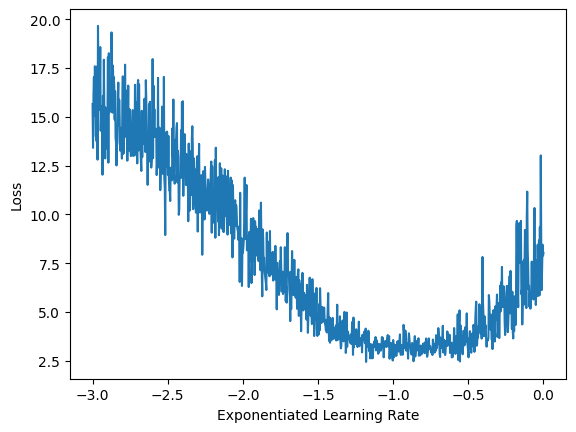

In [165]:
plt.plot(lri, lossi)
plt.xlabel('Exponentiated Learning Rate')
plt.ylabel('Loss')

Optimal learning rate is somewhere around -1.0, e.g. 0.1.

Let's set this learning rate and run the gradient descent for more iterations

In [166]:
for i in range(10000):

    # minibatch construct 
    ix = torch.randint(0, X.shape[0], (32, ))

    emb = C[X[ix]] 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None    
    loss.backward()
    
    lr = 0.1
    
    for p in parameters:
        p.data += -lr * p.grad
    

6.209714889526367
6.779606342315674
5.127408981323242
5.648926734924316
7.164144039154053
5.046341419219971
5.2309441566467285
5.192543983459473
5.2721076011657715
5.172827243804932
4.361598491668701
4.372321128845215
3.9505879878997803
4.162769317626953
4.159543991088867
4.08170223236084
3.819948673248291
3.160475254058838
4.520013809204102
3.8568577766418457
3.418598175048828
3.6622767448425293
3.2503573894500732
3.536266326904297
3.9018237590789795
3.376117706298828
4.178877353668213
4.057367324829102
3.634542465209961
3.6979751586914062
4.112033367156982
3.2621970176696777
3.0333335399627686
2.960139513015747
4.267174243927002
3.5399298667907715
3.0770952701568604
2.686868190765381
3.79726243019104
3.118925094604492
3.7345566749572754
2.9502785205841064
3.0585806369781494
3.0621349811553955
4.136501789093018
2.616487741470337
3.421281099319458
3.2035255432128906
3.0098602771759033
3.2079567909240723
3.1218996047973633
3.502321720123291
3.477017641067505
3.2214720249176025
3.1543328

Let's also log the loss for the entire dataset

In [167]:
emb = C[X] 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.4630768299102783


## Embeddings visualization

Remember that we're using embeddings for the characters in the input layer of the neural network. These embeddings we can now visualize here

In [168]:
C.shape

torch.Size([27, 2])

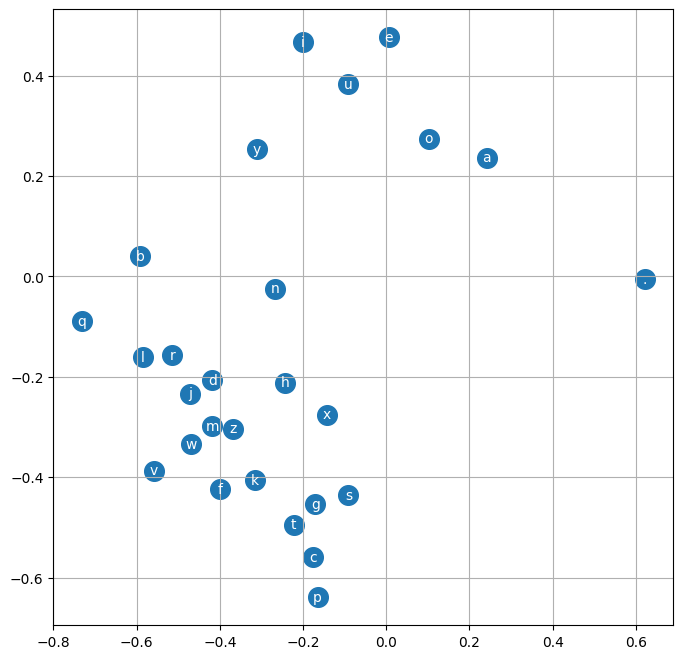

In [169]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color="white")
plt.grid("minor")